In [1]:
"""Test snippet for SSMSToPyDDMMapper.

This can be run in a Jupyter notebook to verify that PyDDM models
constructed from ssms configs produce distributions matching ssms simulators.
"""

# %% Cell 1: Setup
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.interpolate import interp1d

# Import ssms components
from ssms.config import model_config
from ssms.basic_simulators.simulator import simulator
from ssms.external_simulators import SSMSToPyDDMMapper


In [2]:
# %% Cell 2: Test DDM model
print("=" * 60)
print("Testing: DDM (constant drift, constant boundary)")
print("=" * 60)

# Get model config
ddm_config = model_config["ddm"]
print(f"Model: {ddm_config['name']}")
print(f"Parameters: {ddm_config['params']}")

# Check compatibility
is_compat, reason = SSMSToPyDDMMapper.is_compatible(ddm_config)
print(f"Compatible with PyDDM: {is_compat} ({reason})")

# Define parameters
theta_ddm = {
    "v": 1.5,    # drift rate
    "a": 2.0,    # boundary
    "z": 0.5,    # starting point (proportion)
    "t": 0.3,    # non-decision time
}

# Simulation settings
generator_config = {
    "delta_t": 0.001,
    "max_t": 20.0,
    "n_samples": 100000,  # Large sample for good histogram
}

# Run ssms simulator
print("\nRunning ssms simulator...")
ssms_samples = simulator(
    theta=theta_ddm,
    model="ddm",
    n_samples=generator_config["n_samples"],
    delta_t=generator_config["delta_t"],
    max_t=generator_config["max_t"],
    random_state=42,
)

# Build PyDDM model
print("Building PyDDM model...")
pyddm_model = SSMSToPyDDMMapper.build_pyddm_model(
    model_config=ddm_config,
    theta=theta_ddm,
    generator_config=generator_config,
)

# Solve PyDDM model
print("Solving PyDDM model...")
solution = pyddm_model.solve()

# Extract distributions
t_domain = pyddm_model.t_domain()
pdf_correct = solution.pdf("correct")
pdf_error = solution.pdf("error")

# Check normalization
total_prob = integrate.trapezoid(pdf_correct, t_domain) + integrate.trapezoid(
    pdf_error, t_domain
)
print(f"PyDDM total probability: {total_prob:.4f}")

Testing: DDM (constant drift, constant boundary)
Model: ddm
Parameters: ['v', 'a', 'z', 't']
Compatible with PyDDM: True (Compatible)

Running ssms simulator...
Building PyDDM model...
Solving PyDDM model...
PyDDM total probability: 0.9999


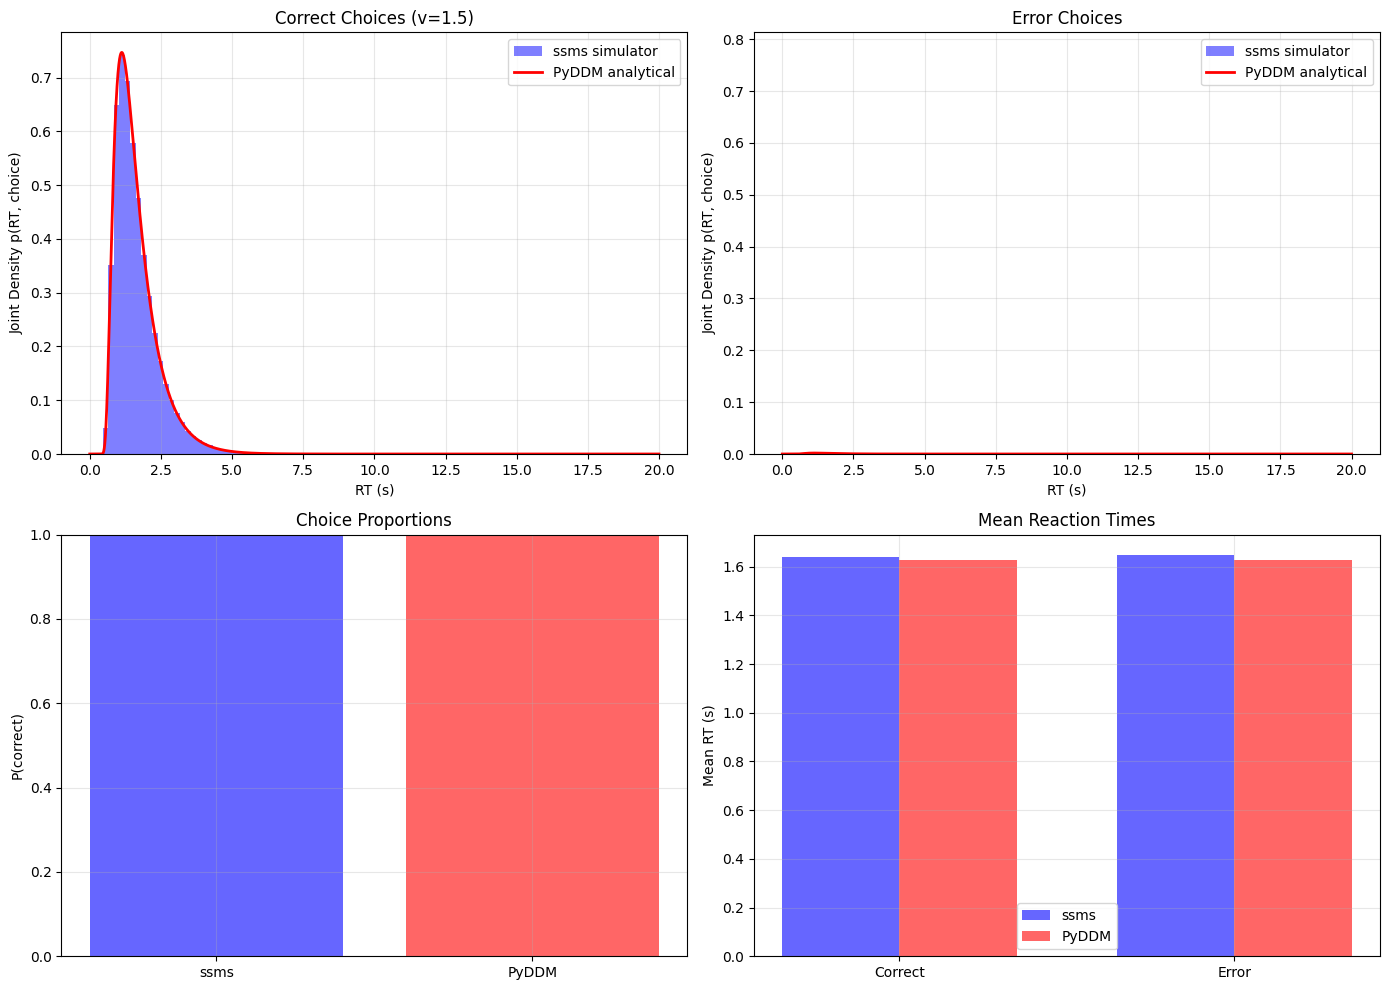


Summary Statistics:
ssms   P(correct): 0.9976, Mean RT(correct): 1.6395
PyDDM  P(correct): 0.9974, Mean RT(correct): 1.6271


In [3]:
# %% Cell 3: Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Calculate choice proportions first (needed for scaling histograms)
choice_mask = (ssms_samples["choices"].ravel() == 1) & (ssms_samples["rts"].ravel() > 0)
error_mask = (ssms_samples["choices"].ravel() == -1) & (ssms_samples["rts"].ravel() > 0)
ssms_correct_rts = ssms_samples["rts"].ravel()[choice_mask]
ssms_error_rts = ssms_samples["rts"].ravel()[error_mask]
ssms_p_correct = np.mean(ssms_samples["choices"].ravel() == 1)
ssms_p_error = np.mean(ssms_samples["choices"].ravel() == -1)

# Correct choices
ax = axes[0, 0]
# Plot ssms histogram scaled by choice proportion to match PyDDM's joint density
counts, bins, patches = ax.hist(
    ssms_correct_rts,
    bins=50,
    density=True,
    alpha=0.5,
    label="ssms simulator",
    color="blue",
)
# Scale the histogram heights by choice proportion
for patch in patches:
    patch.set_height(patch.get_height() * ssms_p_correct)

# PyDDM PDF (already joint density)
ax.plot(t_domain, pdf_correct, "r-", linewidth=2, label="PyDDM analytical")
ax.set_xlabel("RT (s)")
ax.set_ylabel("Joint Density p(RT, choice)")
ax.set_title(f"Correct Choices (v={theta_ddm['v']})")
ax.legend()
ax.grid(alpha=0.3)

# Error choices
ax = axes[0, 1]
counts, bins, patches = ax.hist(
    ssms_error_rts,
    bins=50,
    density=True,
    alpha=0.5,
    label="ssms simulator",
    color="blue",
)
# Scale the histogram heights by choice proportion
for patch in patches:
    patch.set_height(patch.get_height() * ssms_p_error)

ax.plot(t_domain, pdf_error, "r-", linewidth=2, label="PyDDM analytical")
ax.set_xlabel("RT (s)")
ax.set_ylabel("Joint Density p(RT, choice)")
ax.set_title("Error Choices")
ax.legend()
ax.grid(alpha=0.3)

# Choice proportions
ax = axes[1, 0]
# ssms_p_correct already calculated above
pyddm_p_correct = integrate.trapezoid(pdf_correct, t_domain)
ax.bar(
    ["ssms", "PyDDM"],
    [ssms_p_correct, pyddm_p_correct],
    color=["blue", "red"],
    alpha=0.6,
)
ax.set_ylabel("P(correct)")
ax.set_title("Choice Proportions")
ax.grid(alpha=0.3)
ax.set_ylim([0, 1])

# Mean RT comparison
ax = axes[1, 1]
ssms_mean_rt_correct = np.mean(ssms_correct_rts) if len(ssms_correct_rts) > 0 else 0
ssms_mean_rt_error = np.mean(ssms_error_rts) if len(ssms_error_rts) > 0 else 0

# Compute mean RT from PyDDM PDF
pyddm_mean_rt_correct = integrate.trapezoid(t_domain * pdf_correct, t_domain) / max(
    integrate.trapezoid(pdf_correct, t_domain), 1e-10
)
pyddm_mean_rt_error = integrate.trapezoid(t_domain * pdf_error, t_domain) / max(
    integrate.trapezoid(pdf_error, t_domain), 1e-10
)

x = np.arange(2)
width = 0.35
ax.bar(x - width / 2, [ssms_mean_rt_correct, ssms_mean_rt_error], width, label="ssms", color="blue", alpha=0.6)
ax.bar(
    x + width / 2,
    [pyddm_mean_rt_correct, pyddm_mean_rt_error],
    width,
    label="PyDDM",
    color="red",
    alpha=0.6,
)
ax.set_ylabel("Mean RT (s)")
ax.set_title("Mean Reaction Times")
ax.set_xticks(x)
ax.set_xticklabels(["Correct", "Error"])
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("Summary Statistics:")
print("=" * 60)
print(f"ssms   P(correct): {ssms_p_correct:.4f}, Mean RT(correct): {ssms_mean_rt_correct:.4f}")
print(f"PyDDM  P(correct): {pyddm_p_correct:.4f}, Mean RT(correct): {pyddm_mean_rt_correct:.4f}")


Testing: Ornstein (leaky integration)
Model: ornstein
Parameters: ['v', 'a', 'z', 'g', 't']
Compatible with PyDDM: True (Compatible)

Running ssms simulator...
Building PyDDM model...
Solving PyDDM model...


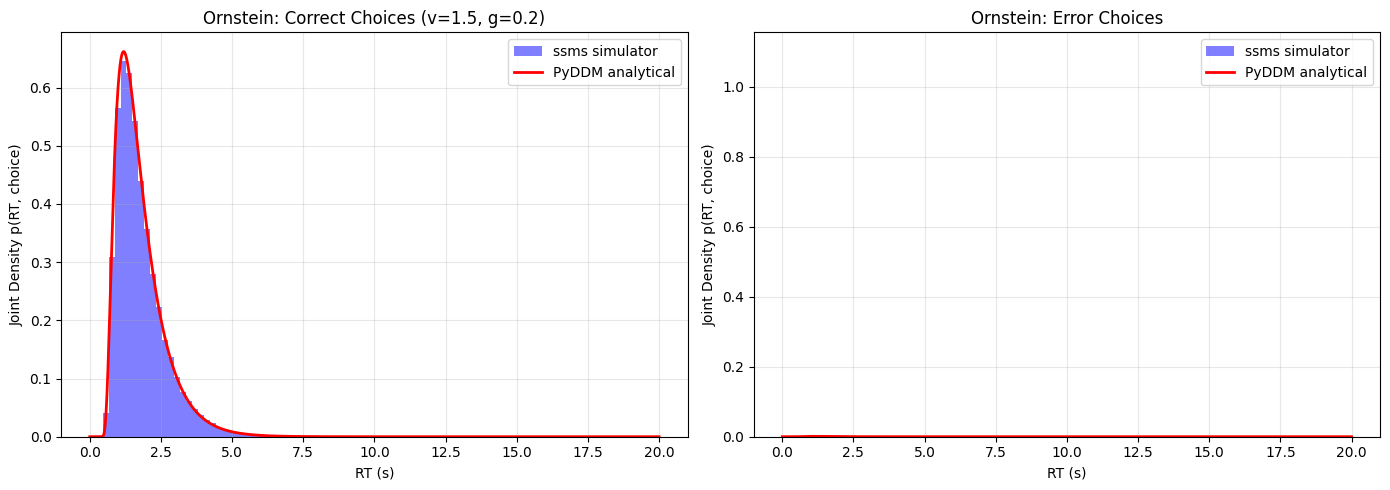


Summary Statistics (Ornstein):
ssms   P(correct): 0.9987
PyDDM  P(correct): 0.9985


In [4]:
# %% Cell 4: Test Ornstein model (position-dependent drift)
print("\n" + "=" * 60)
print("Testing: Ornstein (leaky integration)")
print("=" * 60)

ornstein_config = model_config["ornstein"]
print(f"Model: {ornstein_config['name']}")
print(f"Parameters: {ornstein_config['params']}")

is_compat, reason = SSMSToPyDDMMapper.is_compatible(ornstein_config)
print(f"Compatible with PyDDM: {is_compat} ({reason})")

# Define parameters (includes leak term 'g')
theta_ornstein = {
    "v": 1.5,
    "a": 2.0,
    "z": 0.5,
    "t": 0.3,
    "g": 0.2,  # leak parameter
}

# Run ssms simulator
print("\nRunning ssms simulator...")
ssms_samples_orn = simulator(
    theta=theta_ornstein,
    model="ornstein",
    n_samples=generator_config["n_samples"],
    delta_t=generator_config["delta_t"],
    max_t=generator_config["max_t"],
    random_state=42,
)

# Build PyDDM model
print("Building PyDDM model...")
pyddm_model_orn = SSMSToPyDDMMapper.build_pyddm_model(
    model_config=ornstein_config,
    theta=theta_ornstein,
    generator_config=generator_config,
)

# Solve
print("Solving PyDDM model...")
solution_orn = pyddm_model_orn.solve()

# Extract
t_domain_orn = pyddm_model_orn.t_domain()
pdf_correct_orn = solution_orn.pdf("correct")
pdf_error_orn = solution_orn.pdf("error")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Calculate choice proportions for Ornstein
choice_mask_orn = (ssms_samples_orn["choices"].ravel() == 1) & (ssms_samples_orn["rts"].ravel() > 0)
error_mask_orn = (ssms_samples_orn["choices"].ravel() == -1) & (ssms_samples_orn["rts"].ravel() > 0)
ssms_correct_orn_rts = ssms_samples_orn["rts"].ravel()[choice_mask_orn]
ssms_error_orn_rts = ssms_samples_orn["rts"].ravel()[error_mask_orn]
ssms_p_correct_orn = np.mean(ssms_samples_orn["choices"].ravel() == 1)
ssms_p_error_orn = np.mean(ssms_samples_orn["choices"].ravel() == -1)

ax = axes[0]
# Plot histogram scaled by choice proportion
counts, bins, patches = ax.hist(
    ssms_correct_orn_rts,
    bins=50,
    density=True,
    alpha=0.5,
    label="ssms simulator",
    color="blue",
)
for patch in patches:
    patch.set_height(patch.get_height() * ssms_p_correct_orn)

ax.plot(t_domain_orn, pdf_correct_orn, "r-", linewidth=2, label="PyDDM analytical")
ax.set_xlabel("RT (s)")
ax.set_ylabel("Joint Density p(RT, choice)")
ax.set_title(f"Ornstein: Correct Choices (v={theta_ornstein['v']}, g={theta_ornstein['g']})")
ax.legend()
ax.grid(alpha=0.3)

ax = axes[1]
counts, bins, patches = ax.hist(
    ssms_error_orn_rts,
    bins=50,
    density=True,
    alpha=0.5,
    label="ssms simulator",
    color="blue",
)
for patch in patches:
    patch.set_height(patch.get_height() * ssms_p_error_orn)

ax.plot(t_domain_orn, pdf_error_orn, "r-", linewidth=2, label="PyDDM analytical")
ax.set_xlabel("RT (s)")
ax.set_ylabel("Joint Density p(RT, choice)")
ax.set_title("Ornstein: Error Choices")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ssms_p_correct_orn already calculated above
pyddm_p_correct_orn = integrate.trapezoid(pdf_correct_orn, t_domain_orn)

print("\n" + "=" * 60)
print("Summary Statistics (Ornstein):")
print("=" * 60)
print(f"ssms   P(correct): {ssms_p_correct_orn:.4f}")
print(f"PyDDM  P(correct): {pyddm_p_correct_orn:.4f}")

In [5]:
# %% Cell 5: Test incompatible model (should raise error)
print("\n" + "=" * 60)
print("Testing: Incompatible Models")
print("=" * 60)

# Test race model (multi-particle)
race_config = model_config["race_3"]
is_compat, reason = SSMSToPyDDMMapper.is_compatible(race_config)
print(f"\nrace_3: Compatible={is_compat}, Reason: {reason}")

# Test levy model (non-Gaussian noise)
levy_config = model_config["levy"]
is_compat, reason = SSMSToPyDDMMapper.is_compatible(levy_config)
print(f"levy: Compatible={is_compat}, Reason: {reason}")

# Test full_ddm (inter-trial variability)
full_ddm_config = model_config["full_ddm"]
is_compat, reason = SSMSToPyDDMMapper.is_compatible(full_ddm_config)
print(f"full_ddm: Compatible={is_compat}, Reason: {reason}")

# Try to build race model (should fail)
print("\nAttempting to build race_3 model (should raise ValueError)...")
try:
    SSMSToPyDDMMapper.build_pyddm_model(
        model_config=race_config,
        theta={"v0": 1.0, "v1": 1.2, "v2": 0.8, "a": 2.0, "z": 0.5, "t": 0.3},
        generator_config=generator_config,
    )
    print("ERROR: Should have raised ValueError!")
except ValueError as e:
    print(f"✓ Correctly raised ValueError: {e}")

print("\n" + "=" * 60)
print("All tests complete!")
print("=" * 60)


Testing: Incompatible Models

race_3: Compatible=False, Reason: Multi-particle model (race, 2 accumulators)
levy: Compatible=False, Reason: Non-Gaussian noise (levy) not supported by PyDDM
full_ddm: Compatible=False, Reason: Inter-trial variability parameters {'sz', 'sv', 'st'} require numerical integration

Attempting to build race_3 model (should raise ValueError)...
✓ Correctly raised ValueError: Model 'race_3' not compatible with PyDDM: Multi-particle model (race, 2 accumulators)

All tests complete!
